# AAPL Stock Price Prediction using LSTM

This notebook implements a Long Short-Term Memory (LSTM) neural network to predict Apple Inc. (AAPL) stock prices using historical data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
df = pd.read_csv('stock_price_data/AAPL_adjusted.csv')
print(f"Data shape: {df.shape}")
df.head()

Data shape: (5787, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03 00:00:00-05:00,0.787983,0.845274,0.764034,0.841048,535796800,0.0,0.0
1,2000-01-04 00:00:00-05:00,0.813342,0.831186,0.760277,0.770139,512377600,0.0,0.0
2,2000-01-05 00:00:00-05:00,0.779530,0.830716,0.773895,0.781408,778321600,0.0,0.0
3,2000-01-06 00:00:00-05:00,0.797375,0.803949,0.713787,0.713787,767972800,0.0,0.0
4,2000-01-07 00:00:00-05:00,0.725057,0.758868,0.717544,0.747598,460734400,0.0,0.0


In [3]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
df.head()

Date range: 2000-01-03 05:00:00+00:00 to 2022-12-30 05:00:00+00:00


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03 05:00:00+00:00,0.787983,0.845274,0.764034,0.841048,535796800,0.0,0.0
1,2000-01-04 05:00:00+00:00,0.813342,0.831186,0.760277,0.770139,512377600,0.0,0.0
2,2000-01-05 05:00:00+00:00,0.779530,0.830716,0.773895,0.781408,778321600,0.0,0.0
3,2000-01-06 05:00:00+00:00,0.797375,0.803949,0.713787,0.713787,767972800,0.0,0.0
4,2000-01-07 05:00:00+00:00,0.725057,0.758868,0.717544,0.747598,460734400,0.0,0.0


In [4]:
print("Missing values:")
print(df.isnull().sum())

Missing values:
Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


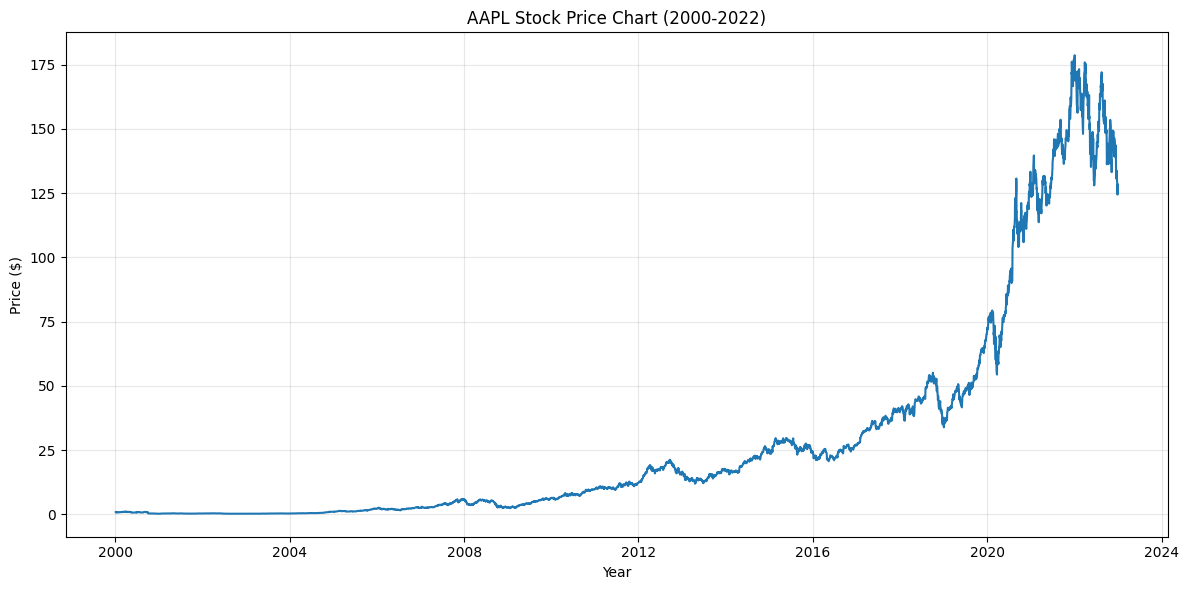

In [5]:
# Plot the stock price over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.title('AAPL Stock Price Chart (2000-2022)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [6]:
df = df[['Date', 'Close']]
print(f"Selected data shape: {df.shape}")
df.head()

Selected data shape: (5787, 2)


,Date,Close
0,2000-01-03 05:00:00+00:00,0.841048
1,2000-01-04 05:00:00+00:00,0.770139
2,2000-01-05 05:00:00+00:00,0.781408
3,2000-01-06 05:00:00+00:00,0.713787
4,2000-01-07 05:00:00+00:00,0.747598


In [7]:
# Create lagged features for time series prediction
df = deepcopy(df)
df.set_index('Date', inplace=True)

# Create 7 days of lagged features
for i in range(1, 8):
    df[f'Close_shift_{i}'] = df['Close'].shift(i)

df.dropna(inplace=True)
print(f"Shape after creating lagged features: {df.shape}")
df.head()

Shape after creating lagged features: (5780, 8)


,Close,Close_shift_1,Close_shift_2,Close_shift_3,Close_shift_4,Close_shift_5,Close_shift_6,Close_shift_7
Date,,,,,,,,
2000-01-12 05:00:00+00:00,0.655088,0.696882,0.734449,0.747598,0.713787,0.781408,0.770139,0.841048
2000-01-13 05:00:00+00:00,0.726935,0.655088,0.696882,0.734449,0.747598,0.713787,0.781408,0.770139
2000-01-14 05:00:00+00:00,0.754641,0.726935,0.655088,0.696882,0.734449,0.747598,0.713787,0.781408
2000-01-18 05:00:00+00:00,0.780939,0.754641,0.726935,0.655088,0.696882,0.734449,0.747598,0.713787
2000-01-19 05:00:00+00:00,0.800662,0.780939,0.754641,0.726935,0.655088,0.696882,0.734449,0.747598


In [8]:
df_to_np = df.to_numpy()
print(f"Numpy array shape: {df_to_np.shape}")

scaler = MinMaxScaler(feature_range=(0, 1))
df_to_np_scaled = scaler.fit_transform(df_to_np)
print(f"Scaled data shape: {df_to_np_scaled.shape}")
df_to_np_scaled[:5]

Numpy array shape: (5780, 8)
Scaled data shape: (5780, 8)


array([[0.00256619, 0.00280039, 0.00301092, 0.0030846 , 0.00289513,
        0.00327407, 0.00321092, 0.00360828],
       [0.00296881, 0.00256619, 0.00280039, 0.00301092, 0.0030846 ,
        0.00289513, 0.00327407, 0.00321092],
       [0.00312407, 0.00296881, 0.00256619, 0.00280039, 0.00301092,
        0.0030846 , 0.00289513, 0.00327407],
       [0.00327144, 0.00312407, 0.00296881, 0.00256619, 0.00280039,
        0.00301092, 0.0030846 , 0.00289513],
       [0.00338197, 0.00327144, 0.00312407, 0.00296881, 0.00256619,
        0.00280039, 0.00301092, 0.0030846 ]])

In [9]:
X = df_to_np_scaled[:, 1:]  # All columns except the first (Close)
X = deepcopy(np.flip(X, axis=1))  # Reverse the order to have most recent first
y = df_to_np_scaled[:, 0]  # First column (Close price)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (5780, 7)
y shape: (5780,)


In [10]:
# Split the data into train and test sets (95% train, 5% test)
split_index = int(len(X) * 0.95)
print(f"Split index: {split_index}")
print(f"Training samples: {split_index}")
print(f"Test samples: {len(X) - split_index}")

Split index: 5491
Training samples: 5491
Test samples: 289


In [11]:
# Split and reshape data for LSTM
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

# Reshape for LSTM: (samples, timesteps, features)
X_train = X_train.reshape((-1, 7, 1))
X_test = X_test.reshape((-1, 7, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5491, 7, 1)
X_test shape: (289, 7, 1)
y_train shape: (5491, 1)
y_test shape: (289, 1)


In [12]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: torch.Size([5491, 7, 1])
X_test shape: torch.Size([289, 7, 1])
y_train shape: torch.Size([5491, 1])
y_test shape: torch.Size([289, 1])


In [13]:
# Create Dataset class with proper tensor handling
class StockDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, torch.Tensor):
            self.X = X.clone().detach()
        else:
            self.X = torch.tensor(X).float()
            
        if isinstance(y, torch.Tensor):
            self.y = y.clone().detach()
        else:
            self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 172
Test batches: 10


## LSTM Model Definition

In [14]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get the last output
        out = self.dropout(out[:, -1, :])
        
        # Decode the hidden state of the last time step
        out = self.fc(out)
        
        return out

model = LSTMModel(input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Total parameters: 31,051
Trainable parameters: 31,051


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Learning rate scheduler: {scheduler}")

Using device: cpu
Loss function: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
Learning rate scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x31a4112b0>


## Training the Model

In [16]:
# Training loop
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 20
patience_counter = 0

print("Starting training...")
print("=" * 50)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_lstm_model.pth')
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    # Early stopping check
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print("Training completed!")
print(f"Best validation loss: {best_val_loss:.6f}")

Starting training...
Epoch [10/100], Train Loss: 0.000432, Val Loss: 0.001325
Epoch [20/100], Train Loss: 0.000335, Val Loss: 0.001065
Epoch [30/100], Train Loss: 0.000304, Val Loss: 0.001233
Epoch [40/100], Train Loss: 0.000315, Val Loss: 0.001149
Epoch [50/100], Train Loss: 0.000260, Val Loss: 0.000877
Epoch [60/100], Train Loss: 0.000251, Val Loss: 0.001519
Epoch [70/100], Train Loss: 0.000262, Val Loss: 0.000813
Epoch [80/100], Train Loss: 0.000236, Val Loss: 0.000805
Epoch [90/100], Train Loss: 0.000241, Val Loss: 0.001483
Epoch [100/100], Train Loss: 0.000219, Val Loss: 0.001024
Early stopping at epoch 100
Training completed!
Best validation loss: 0.000805


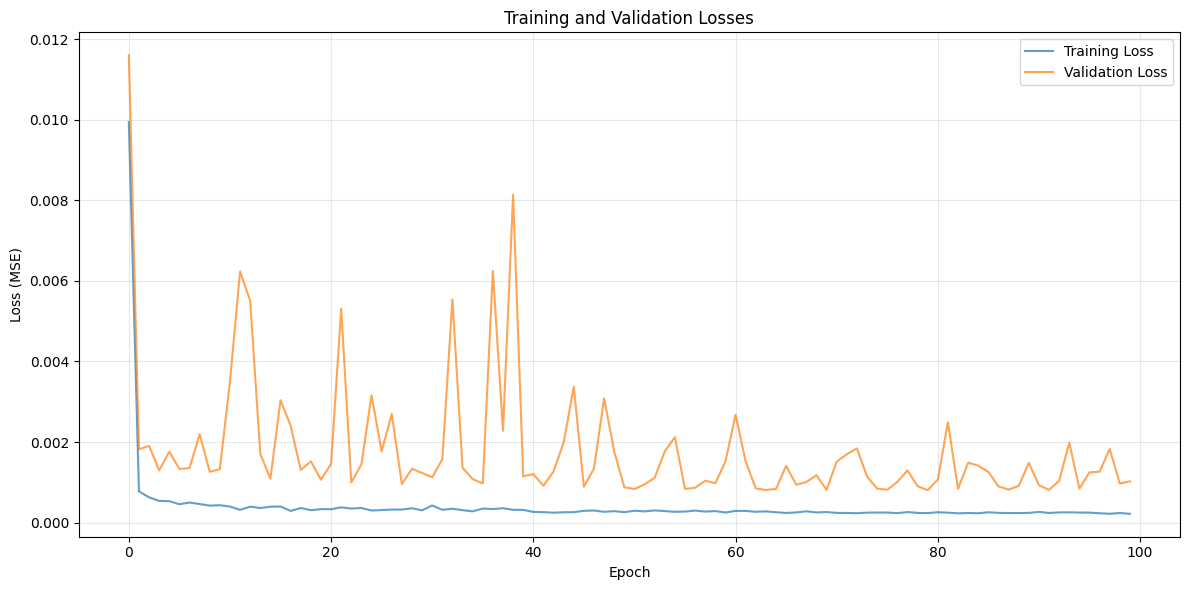

In [17]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Model Evaluation

In [18]:
# Load the best model
model.load_state_dict(torch.load('best_lstm_model.pth'))
model.eval()
print("Best model loaded!")

Best model loaded!


In [19]:
# Evaluate the model
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_y.cpu().numpy())

predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

# Calculate metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mse)

print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")

Model Performance Metrics:
Mean Squared Error (MSE): 0.000861
Root Mean Squared Error (RMSE): 0.029348
Mean Absolute Error (MAE): 0.023788


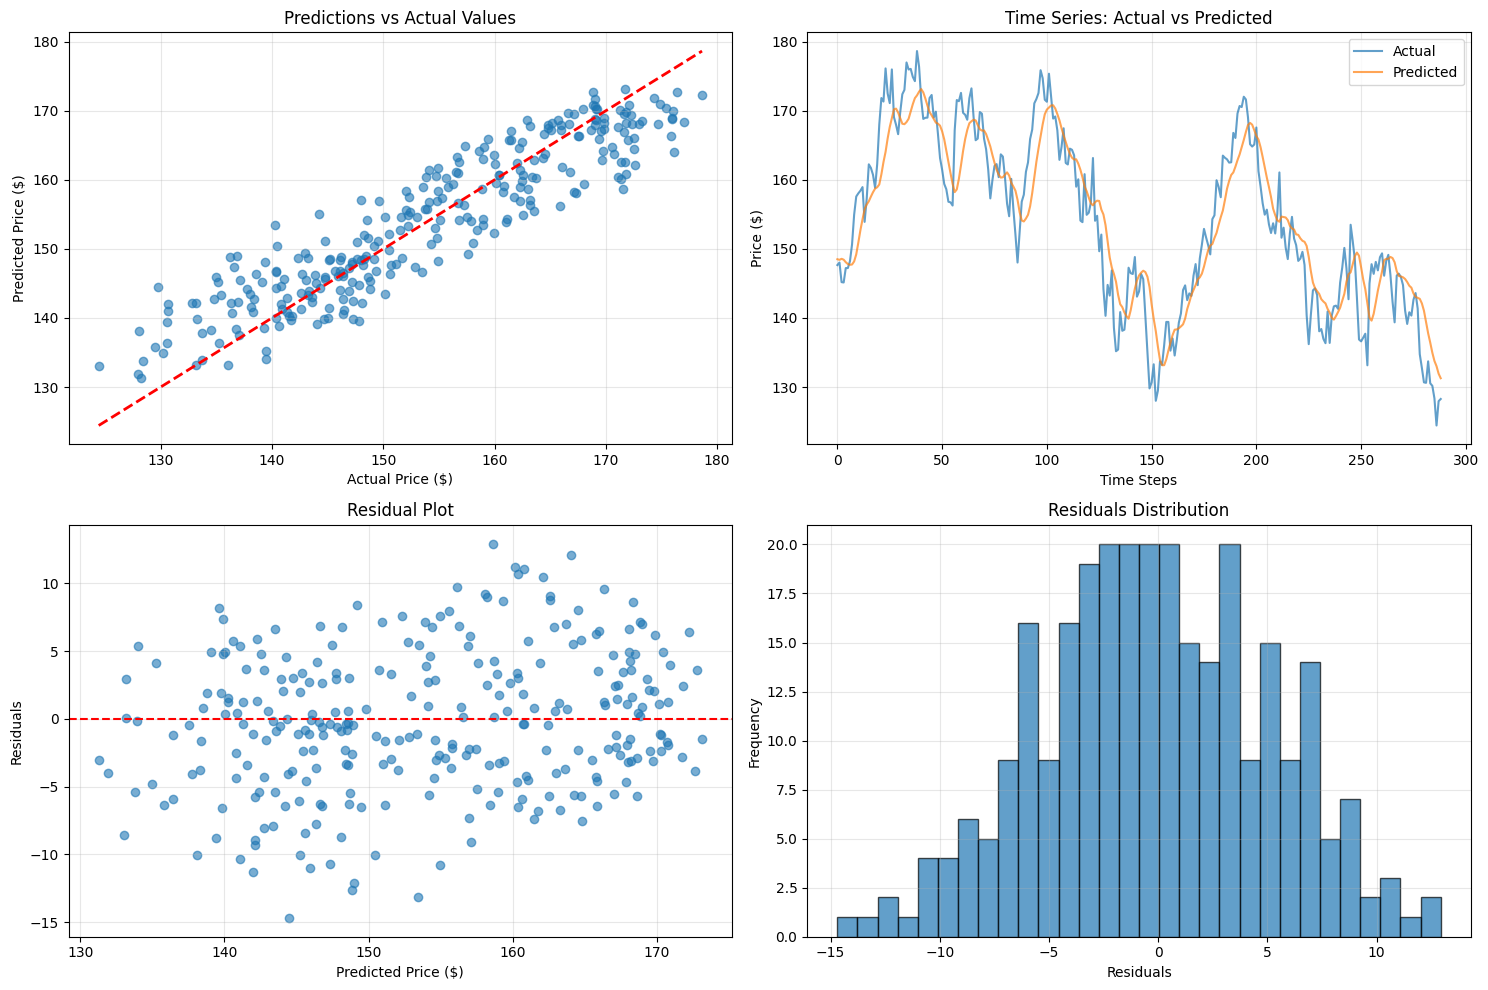


Residual Statistics:
Mean residual: -0.21
Std residual: 5.23
Min residual: -14.69
Max residual: 12.94


In [20]:
# Plot predictions vs actual values
plt.figure(figsize=(15, 10))

# Convert back to original scale for better interpretation
# Create a dummy array with the same shape as the original scaled data (8 columns)
dummy_data = np.zeros((len(actuals), 8))  # 8 columns to match the original scaled data
dummy_data[:, 0] = actuals  # Put actuals in the first column (Close price)
actuals_original = scaler.inverse_transform(dummy_data)[:, 0]

dummy_data = np.zeros((len(predictions), 8))  # 8 columns to match the original scaled data
dummy_data[:, 0] = predictions  # Put predictions in the first column (Close price)
predictions_original = scaler.inverse_transform(dummy_data)[:, 0]

# Plot 1: Predictions vs Actual
plt.subplot(2, 2, 1)
plt.scatter(actuals_original, predictions_original, alpha=0.6)
plt.plot([actuals_original.min(), actuals_original.max()], 
         [actuals_original.min(), actuals_original.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Predictions vs Actual Values')
plt.grid(True, alpha=0.3)

# Plot 2: Time series comparison
plt.subplot(2, 2, 2)
plt.plot(actuals_original, label='Actual', alpha=0.7)
plt.plot(predictions_original, label='Predicted', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.title('Time Series: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Residuals
residuals = actuals_original - predictions_original
plt.subplot(2, 2, 3)
plt.scatter(predictions_original, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# Plot 4: Residuals histogram
plt.subplot(2, 2, 4)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print additional statistics
print(f"\nResidual Statistics:")
print(f"Mean residual: {np.mean(residuals):.2f}")
print(f"Std residual: {np.std(residuals):.2f}")
print(f"Min residual: {np.min(residuals):.2f}")
print(f"Max residual: {np.max(residuals):.2f}")